# Using CNN's with the Cats vs Dogs Dataset

In [1]:


import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

Download the dataset from its original source by running the cell below.

Note that the `zip` file that contains the images is unzipped under the `/tmp` directory.

In [2]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-12-17 06:02:57--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.25.248.114, 2600:1417:3f:580::317f, 2600:1417:3f:59b::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.25.248.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   112MB/s    in 6.2s    

2023-12-17 06:03:04 (126 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



Now the images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [3]:

source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


You will need a directory for cats-v-dogs, and subdirectories for training
and validation. These in turn will need subdirectories for 'cats' and 'dogs'. To accomplish this, complete the `create_train_val_dirs` below:

In [4]:
# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)


def create_train_test_dirs(root_path):
  
  print(f"Creating \'{root_path}\' directory.")

  os.makedirs(root_path)

  training_dir = os.path.join(root_path, 'training')

  os.makedirs(training_dir)
  
  print(f"Training directory created as \'{training_dir}\'.")

  testing_dir = os.path.join(root_path, 'testing')

  os.makedirs(testing_dir)
  
  print(f"Testing directory created as \'{testing_dir}\'.")

  print("Creating the subfolders for storing cats and dogs images.")

  training_cats_dir = os.path.join(training_dir, 'cats')
  
  training_dogs_dir = os.path.join(training_dir, 'dogs')

  os.makedirs(training_cats_dir)
  
  os.makedirs(training_dogs_dir)
  
  print(f"\'{training_cats_dir}\' and \'{training_dogs_dir}\' created.")

  testing_cats_dir = os.path.join(testing_dir, 'cats')
  
  testing_dogs_dir = os.path.join(testing_dir, 'dogs')

  os.makedirs(testing_cats_dir)
  
  os.makedirs(testing_dogs_dir)
  
  print(f"\'{testing_cats_dir}\' and \'{testing_dogs_dir}\' created.")

  pass

try:
  
  create_train_test_dirs(root_path=root_dir)
  
except FileExistsError:
  
  print("You should not be seeing this since the upper directory is removed beforehand")

Creating '/tmp/cats-v-dogs' directory.
Training directory created as '/tmp/cats-v-dogs/training'.
Testing directory created as '/tmp/cats-v-dogs/testing'.
Creating the subfolders for storing cats and dogs images.
'/tmp/cats-v-dogs/training/cats' and '/tmp/cats-v-dogs/training/dogs' created.
'/tmp/cats-v-dogs/testing/cats' and '/tmp/cats-v-dogs/testing/dogs' created.


In [5]:

for rootdir, dirs, files in os.walk(root_dir):
    
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/testing
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/testing/dogs
/tmp/cats-v-dogs/testing/cats


In [6]:

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  import numpy as np

  #Get a list containing the contents of the SOURCE directory:
  files_list = os.listdir(SOURCE)

  total_files = len(files_list)

  #Get total of files used for training:
  total_training_files = int(np.rint(SPLIT_SIZE * total_files))

  #Get total of files used for testing:
  total_testing_files = total_files - total_training_files


  #Create a list of the files used for training, by sampling the files_list:
  training_files = random.sample(files_list, total_training_files)

  #Create a list of the files used for testing.
  
  testing_files = []

  #Loop through each element (named 'file') of the original files_list:
  for file in files_list:

      #create a boolean checker, that can be either True or False:
      bool_check = file in training_files

      if (bool_check == False):

        testing_files.append(file)

  list_of_substrings = SOURCE.split(sep = "/")

  file_class = list_of_substrings[(len(list_of_substrings) - 1)]

  for file in training_files:

    #Retrieve the full file path, by joining the file name to the SOURCE path:
    
    file_path = os.path.join(SOURCE, file)
    
    #Get the file size:
    
    file_size = os.path.getsize(file_path)

    #Check if the size is higher than zero (non-empty images):
    
    if (file_size > 0):

        new_path = os.path.join(TRAINING, file)
        
        #2. Copy the file to this new file path:
        copyfile(file_path, new_path)

    else:
      printed_msg = file + " is zero length, so ignoring."
      
      print(printed_msg)
      
  #Loop through each element (named 'file') of the 'testing_files' list:
  for file in testing_files:

    #Retrieve the full file path, by joining the file name to the SOURCE path:
    file_path = os.path.join(SOURCE, file)
    #Get the file size:
    file_size = os.path.getsize(file_path)

    #Check if the size is higher than zero (non-empty images):
    if (file_size > 0):

        new_path = os.path.join(TESTING, file)

        copyfile(file_path, new_path)

    else:
      #print the message for the zero-sized file
      
      printed_msg = file + " is zero length, so ignoring."
      print(printed_msg)

  pass


In [8]:

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
TESTING_DIR = "/tmp/cats-v-dogs/testing/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
TESTING_CATS_DIR = os.path.join(TESTING_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
TESTING_DOGS_DIR = os.path.join(TESTING_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_CATS_DIR)) > 0:
  for file in os.scandir(TESTING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
  for file in os.scandir(TESTING_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for testing
There are 1250 images of dogs for testing


In [9]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  from tensorflow.keras.preprocessing.image import ImageDataGenerator

  train_datagen = ImageDataGenerator(rescale = (1.0)/(255.))

  train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = 200,
                                                      class_mode = "binary",
                                                      target_size = (150, 150))

  validation_datagen = ImageDataGenerator(rescale = (1.0)/(255.))


  validation_generator = validation_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                                batch_size = 20,
                                                                class_mode = "binary",
                                                                target_size = (150, 150))

  return train_generator, validation_generator

In [11]:

train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [12]:

def create_model():

  model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),

    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),

    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),

    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics=['accuracy'])


  return model

Now it is time to train your model!

**Note:** You can ignore the `UserWarning: Possibly corrupt EXIF data.` warnings.

In [13]:

model = create_model()

history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
 26/113 [=====>........................] - ETA: 37s - loss: 0.6730 - accuracy: 0.5723

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


113/113 [==============================] - 62s 479ms/step - loss: 0.6049 - accuracy: 0.6572 - val_loss: 0.5235 - val_accuracy: 0.7452
Epoch 2/15
113/113 [==============================] - 53s 465ms/step - loss: 0.4844 - accuracy: 0.7668 - val_loss: 0.4773 - val_accuracy: 0.7872
Epoch 3/15
113/113 [==============================] - 53s 465ms/step - loss: 0.4338 - accuracy: 0.7967 - val_loss: 0.4303 - val_accuracy: 0.8080
Epoch 4/15
113/113 [==============================] - 55s 490ms/step - loss: 0.3911 - accuracy: 0.8236 - val_loss: 0.4107 - val_accuracy: 0.8164
Epoch 5/15
113/113 [==============================] - 53s 466ms/step - loss: 0.3533 - accuracy: 0.8430 - val_loss: 0.3916 - val_accuracy: 0.8296
Epoch 6/15
113/113 [==============================] - 53s 466ms/step - loss: 0.3231 - accuracy: 0.8604 - val_loss: 0.3889 - val_accuracy: 0.8292
Epoch 7/15
113/113 [==============================] - 53s 473ms/step - loss: 0.3103 - accuracy: 0.8659 - val_loss: 0.3773 - val_accuracy: 0.8

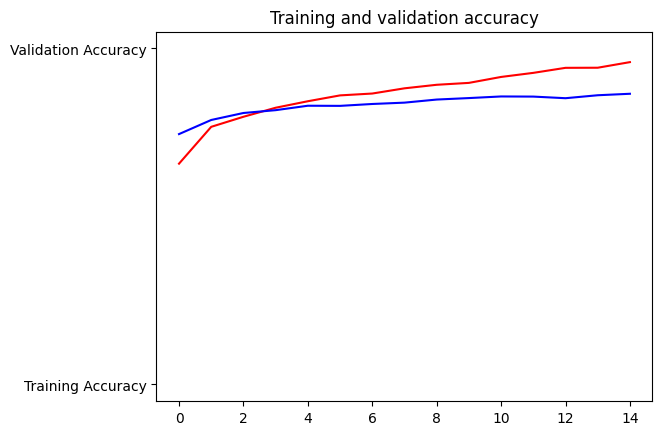

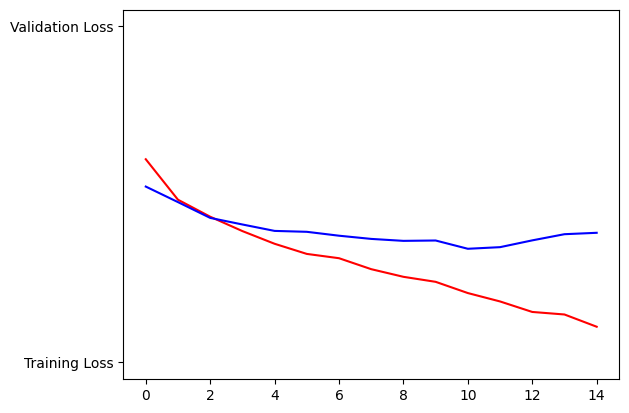

In [14]:

acc=history.history['accuracy']

val_acc=history.history['val_accuracy']

loss=history.history['loss']

val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------

plt.plot(epochs, acc, 'r', "Training Accuracy")

plt.plot(epochs, val_acc, 'b', "Validation Accuracy")

plt.title('Training and validation accuracy')

plt.show()

print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------

plt.plot(epochs, loss, 'r', "Training Loss")

plt.plot(epochs, val_loss, 'b', "Validation Loss")

plt.show()